In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import os
from PIL import Image
import glob
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator

csvdata_dir = "/home/stsubokura/FoodRecognition/data/"

folder = ["cucumberinside_csv","cucumberoutside_csv","eggplant_csv","gumi_csv", "kamaboko_csv", "konnyaku_csv", "marshmallow_csv"]

max_dataarraysize = 4423 

csvs = []
label = []
buffer = 50

for index, name in enumerate(folder):
    dir = csvdata_dir + name
    files = glob.glob(dir + "/*.csv")
    for i, file in enumerate(files):
        csv = pd.read_csv(file, sep = '\t', encoding = "shift-jis", error_bad_lines = False, header = None,skiprows=[0])
        
        data_delbefore = np.array(csv, dtype = np.float32).T
        data_deleted = np.delete(data_delbefore, 0, axis = 0) #delete meaningless law
        data_array = data_deleted - data_deleted.mean(axis=0)

        data_array_zero = np.zeros((2, max_dataarraysize))
        
        for i in range(0, int(max_dataarraysize - data_array.shape[1]), buffer):
            data_array_zero = np.zeros((2, max_dataarraysize))
            data_array_zero[:, :data_array.shape[1]] = data_array
            csvs.append(data_array_zero)
            label.append(index)

csvs = np.asarray(csvs)

csvs = csvs
csvs = csvs.astype('float32')


label = np.asarray(label)
label =  tf.keras.utils.to_categorical(label, 7)

csvs_train, csvs_test, label_train, label_test = train_test_split(csvs, label, test_size=0.1, random_state=111)

print(csvs_train.shape)
print(csvs_train.shape)


(10664, 2, 4423)
(10664, 2, 4423)


In [5]:
np.set_printoptions(threshold=np.inf)
print(csvs_train.shape[1:])

(2, 4423)


In [11]:
# RNNを構築
hid_dim = 32
epochs = 100
#複数のGPUを用いる

with tf.distribute.MirroredStrategy().scope():
    model = Sequential()
    model.add(LSTM(hid_dim, input_shape=csvs_train.shape[1:], activation = 'relu')) # input_shape=(系列長T, x_tの次元), output_shape=(units(=hid_dim),)
    model.add(Dense(label_train.shape[1], activation='softmax'))
    model.summary()

# コンパイル
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# # 実行。出力はなしで設定(verbose=0)。
# history = model.fit(dataarrays_train, label_train, batch_size=, epochs=100, validation_data=(dataarrays_test, label_test))

# 実行。出力はなしで設定(verbose=0)。
history = model.fit(csvs_train, label_train, batch_size=256, epochs=epochs, validation_data=(csvs_test, label_test))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                570368    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 570,599
Trainable params: 570,599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
42/42 [==============================] - 3s 71ms/step - accuracy: 0.3416 - loss: 0.

Epoch 50/100
42/42 [==============================] - 1s 22ms/step - accuracy: 0.9835 - loss: 0.0156 - val_accuracy: 0.9873 - val_loss: 0.0114
Epoch 51/100
42/42 [==============================] - 1s 22ms/step - accuracy: 0.9873 - loss: 0.0104 - val_accuracy: 0.9916 - val_loss: 0.0100
Epoch 52/100
42/42 [==============================] - 1s 22ms/step - accuracy: 0.8215 - loss: 0.1432 - val_accuracy: 0.8895 - val_loss: 0.0791
Epoch 53/100
42/42 [==============================] - 1s 23ms/step - accuracy: 0.9294 - loss: 0.0532 - val_accuracy: 0.9747 - val_loss: 0.0296
Epoch 54/100
42/42 [==============================] - 1s 23ms/step - accuracy: 0.9739 - loss: 0.0276 - val_accuracy: 0.9848 - val_loss: 0.0213
Epoch 55/100
42/42 [==============================] - 1s 22ms/step - accuracy: 0.9822 - loss: 0.0177 - val_accuracy: 0.9730 - val_loss: 0.0193
Epoch 56/100
42/42 [==============================] - 1s 23ms/step - accuracy: 0.9842 - loss: 0.0149 - val_accuracy: 0.9831 - val_loss: 0.0140

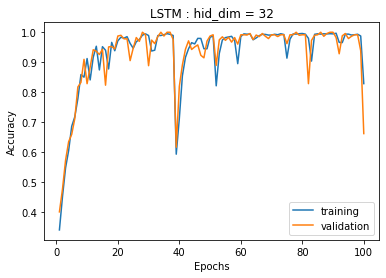

In [12]:
plt.title('LSTM : hid_dim = ' + str(hid_dim))
plt.plot(range(1, epochs+1), history.history['accuracy'], label="training")
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
